In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 2:2+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 10

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'

    epochs = 30  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, in_chans, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, in_chans, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



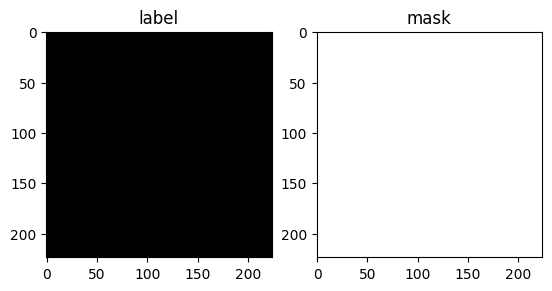

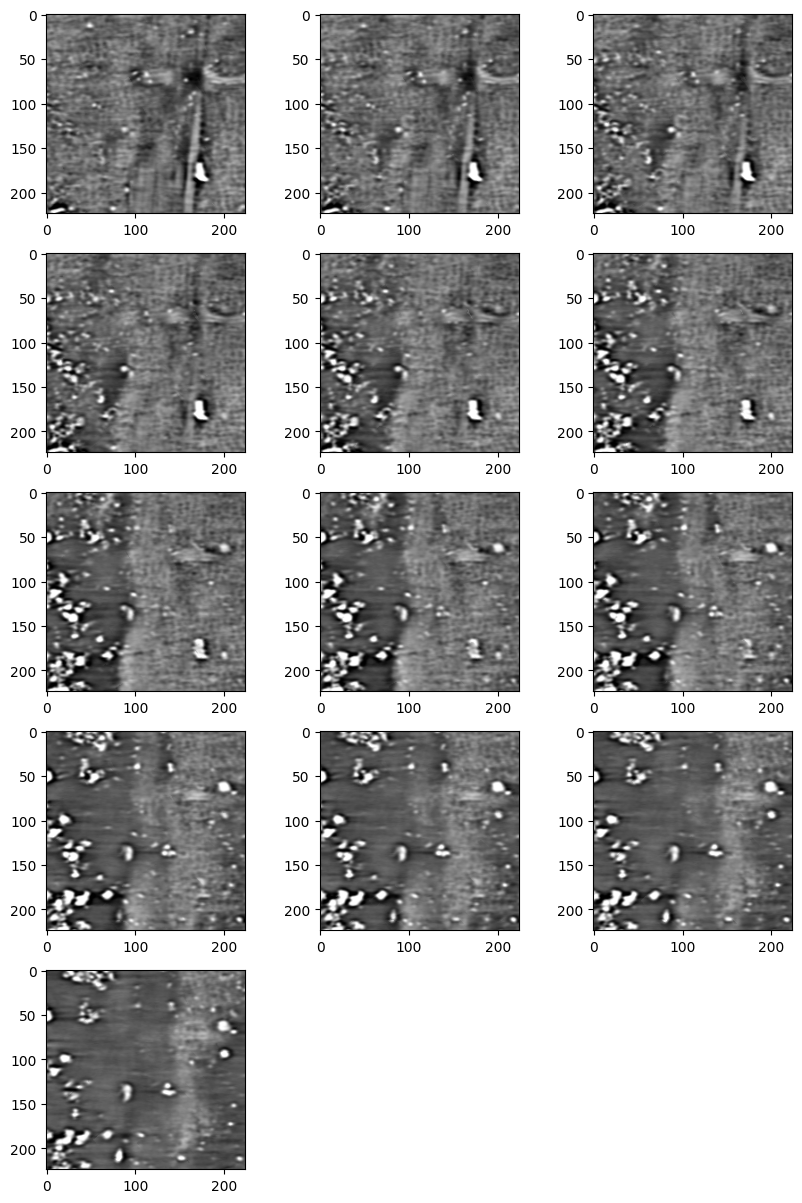

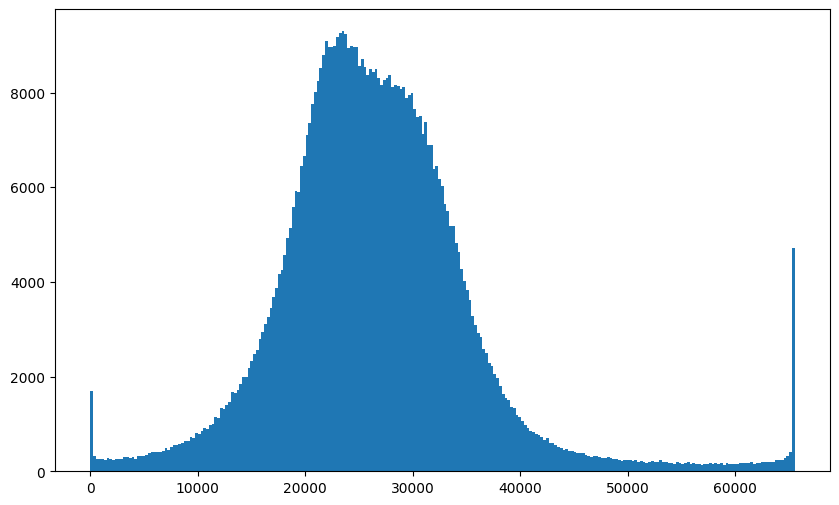

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


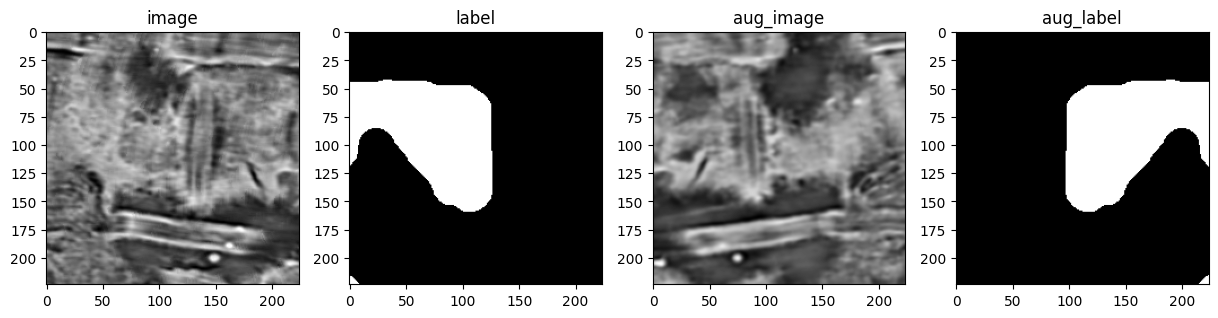

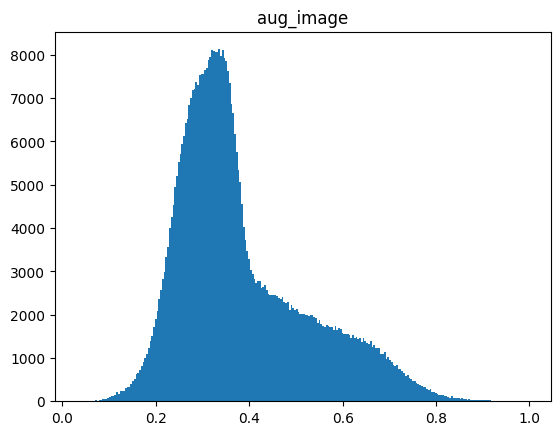

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 4


100%|██████████| 99/99 [00:09<00:00, 10.76it/s]


fbeta: 0.3835
Epoch 1 - avg_train_loss: 1.3373  avg_val_loss: 0.9922  avgScore: 0.3835  time: 145s
Epoch 1 - Save Best Loss: 0.9922  Best Score: 0.3835 Model



100%|██████████| 99/99 [00:08<00:00, 11.26it/s]


fbeta: 0.3930
Epoch 2 - avg_train_loss: 1.1280  avg_val_loss: 0.9281  avgScore: 0.3930  time: 132s
Epoch 2 - Save Best Loss: 0.9281  Best Score: 0.3930 Model



100%|██████████| 99/99 [00:08<00:00, 11.60it/s]


fbeta: 0.4457
Epoch 3 - avg_train_loss: 0.9930  avg_val_loss: 0.7932  avgScore: 0.4457  time: 131s
Epoch 3 - Save Best Loss: 0.7932  Best Score: 0.4457 Model



100%|██████████| 99/99 [00:08<00:00, 11.63it/s]


fbeta: 0.4531
Epoch 4 - avg_train_loss: 0.8909  avg_val_loss: 0.7495  avgScore: 0.4531  time: 131s
Epoch 4 - Save Best Loss: 0.7495  Best Score: 0.4531 Model



100%|██████████| 99/99 [00:08<00:00, 11.97it/s]


fbeta: 0.4877
Epoch 5 - avg_train_loss: 0.8479  avg_val_loss: 0.7185  avgScore: 0.4877  time: 129s
Epoch 5 - Save Best Loss: 0.7185  Best Score: 0.4877 Model



100%|██████████| 99/99 [00:08<00:00, 11.95it/s]


fbeta: 0.4834
Epoch 6 - avg_train_loss: 0.8159  avg_val_loss: 0.7230  avgScore: 0.4834  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.10it/s]


fbeta: 0.4338
Epoch 7 - avg_train_loss: 0.7681  avg_val_loss: 0.7718  avgScore: 0.4338  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.05it/s]


fbeta: 0.3936
Epoch 8 - avg_train_loss: 0.7428  avg_val_loss: 0.7939  avgScore: 0.3936  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.01it/s]


fbeta: 0.5016
Epoch 9 - avg_train_loss: 0.7499  avg_val_loss: 0.7075  avgScore: 0.5016  time: 126s
Epoch 9 - Save Best Loss: 0.7075  Best Score: 0.5016 Model



100%|██████████| 99/99 [00:08<00:00, 11.93it/s]


fbeta: 0.5059
Epoch 10 - avg_train_loss: 0.6729  avg_val_loss: 0.6998  avgScore: 0.5059  time: 127s
Epoch 10 - Save Best Loss: 0.6998  Best Score: 0.5059 Model



100%|██████████| 99/99 [00:08<00:00, 12.02it/s]


fbeta: 0.5130
Epoch 11 - avg_train_loss: 0.6905  avg_val_loss: 0.7112  avgScore: 0.5130  time: 127s
Epoch 11 - Save Best Loss: 0.7112  Best Score: 0.5130 Model



100%|██████████| 99/99 [00:08<00:00, 12.08it/s]


fbeta: 0.5327
Epoch 12 - avg_train_loss: 0.6346  avg_val_loss: 0.7219  avgScore: 0.5327  time: 126s
Epoch 12 - Save Best Loss: 0.7219  Best Score: 0.5327 Model



100%|██████████| 99/99 [00:08<00:00, 12.07it/s]


fbeta: 0.4009
Epoch 13 - avg_train_loss: 0.5970  avg_val_loss: 0.8513  avgScore: 0.4009  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.01it/s]


fbeta: 0.4797
Epoch 14 - avg_train_loss: 0.6285  avg_val_loss: 0.7339  avgScore: 0.4797  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.06it/s]


fbeta: 0.4131
Epoch 15 - avg_train_loss: 0.5643  avg_val_loss: 0.8211  avgScore: 0.4131  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.07it/s]


fbeta: 0.5233
Epoch 16 - avg_train_loss: 0.5773  avg_val_loss: 0.7265  avgScore: 0.5233  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.01it/s]


fbeta: 0.4523
Epoch 17 - avg_train_loss: 0.5468  avg_val_loss: 0.7856  avgScore: 0.4523  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.01it/s]


fbeta: 0.5017
Epoch 18 - avg_train_loss: 0.5052  avg_val_loss: 0.7464  avgScore: 0.5017  time: 126s



100%|██████████| 99/99 [00:08<00:00, 12.04it/s]


fbeta: 0.4662
Epoch 19 - avg_train_loss: 0.4858  avg_val_loss: 0.7630  avgScore: 0.4662  time: 127s



100%|██████████| 99/99 [00:08<00:00, 11.98it/s]


fbeta: 0.4918
Epoch 20 - avg_train_loss: 0.4756  avg_val_loss: 0.7658  avgScore: 0.4918  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.07it/s]


fbeta: 0.4863
Epoch 21 - avg_train_loss: 0.4667  avg_val_loss: 0.7503  avgScore: 0.4863  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.02it/s]


fbeta: 0.4523
Epoch 22 - avg_train_loss: 0.4609  avg_val_loss: 0.8097  avgScore: 0.4523  time: 127s



100%|██████████| 99/99 [00:08<00:00, 11.99it/s]


fbeta: 0.4614
Epoch 23 - avg_train_loss: 0.4362  avg_val_loss: 0.7984  avgScore: 0.4614  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.06it/s]


fbeta: 0.4988
Epoch 24 - avg_train_loss: 0.4229  avg_val_loss: 0.7716  avgScore: 0.4988  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.06it/s]


fbeta: 0.4424
Epoch 25 - avg_train_loss: 0.4075  avg_val_loss: 0.8271  avgScore: 0.4424  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.03it/s]


fbeta: 0.4604
Epoch 26 - avg_train_loss: 0.3990  avg_val_loss: 0.8065  avgScore: 0.4604  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.04it/s]


fbeta: 0.4452
Epoch 27 - avg_train_loss: 0.3917  avg_val_loss: 0.8154  avgScore: 0.4452  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.11it/s]


fbeta: 0.4517
Epoch 28 - avg_train_loss: 0.3818  avg_val_loss: 0.8125  avgScore: 0.4517  time: 127s



100%|██████████| 99/99 [00:08<00:00, 12.06it/s]


fbeta: 0.4631
Epoch 29 - avg_train_loss: 0.3811  avg_val_loss: 0.8026  avgScore: 0.4631  time: 126s



100%|██████████| 99/99 [00:08<00:00, 11.98it/s]


fbeta: 0.4769
Epoch 30 - avg_train_loss: 0.3769  avg_val_loss: 0.7878  avgScore: 0.4769  time: 127s

{"status":200,"message":"ok"}

In [12]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)



fbeta: 0.5350
fbeta: 0.5979
fbeta: 0.5829
fbeta: 0.6219
fbeta: 0.5327


In [13]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5749


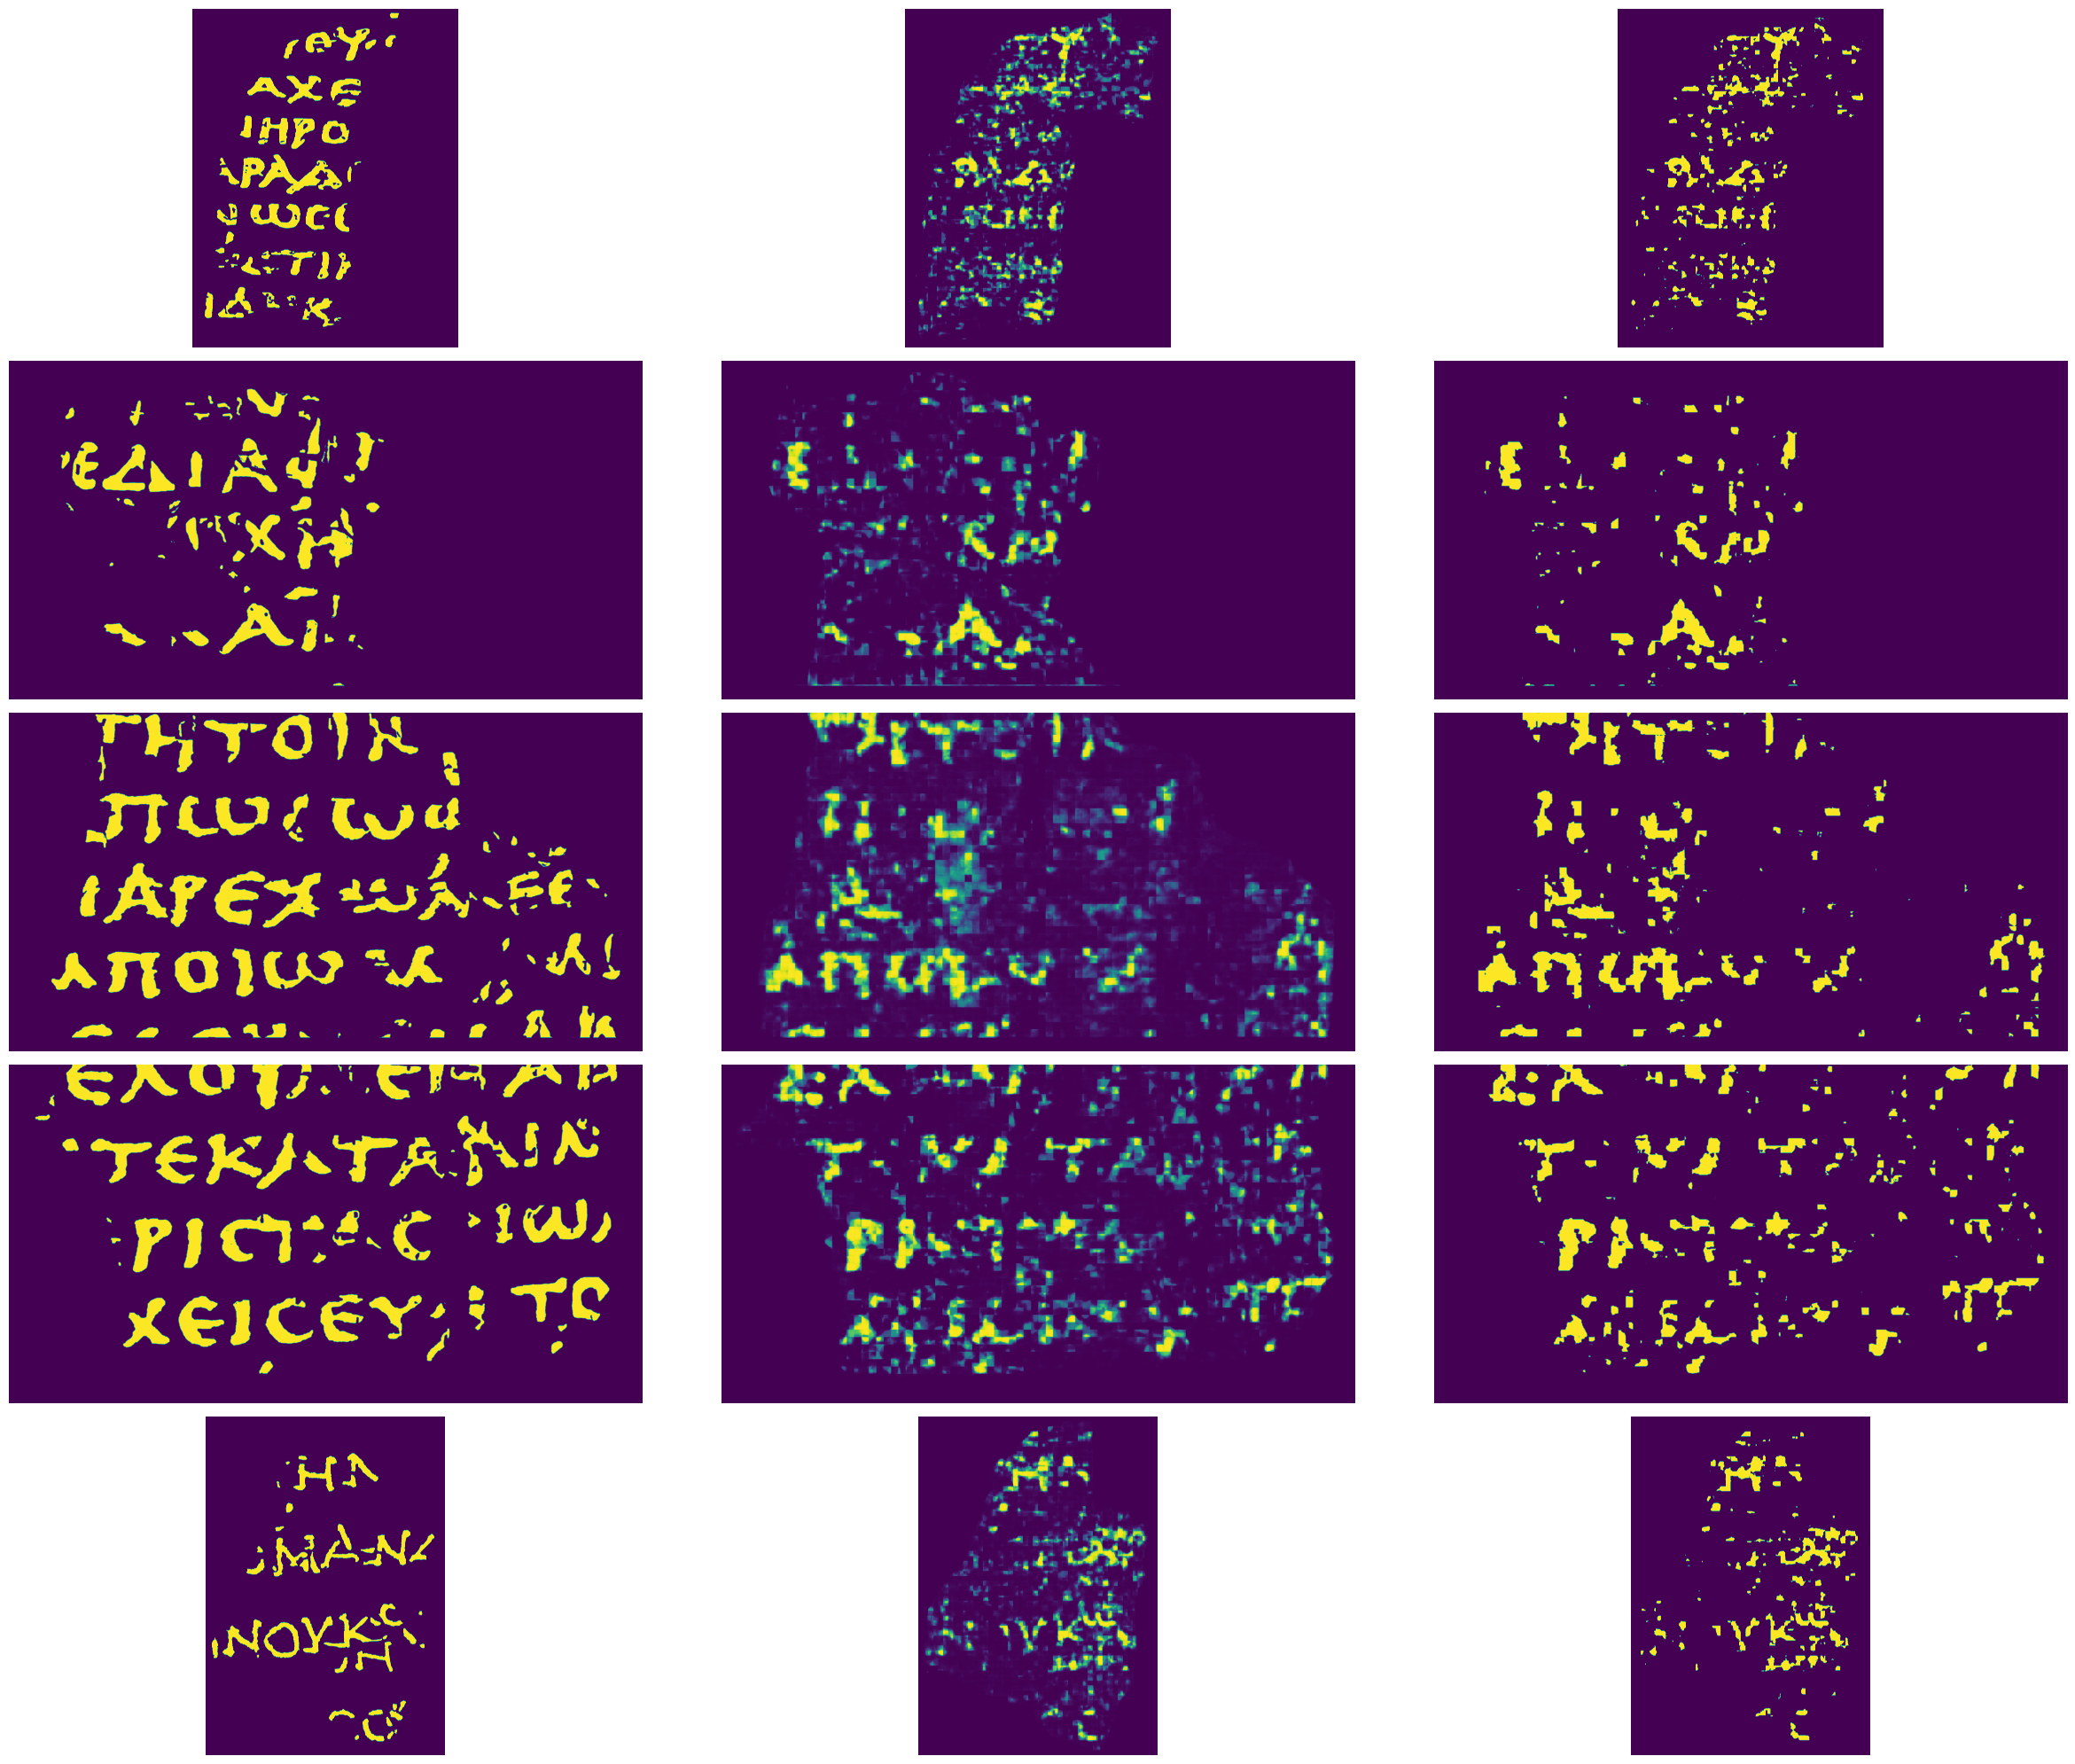

In [14]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)